In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy
import transformers
import numpy as np
import random
from transformers import AdamW, BertTokenizer, get_linear_schedule_with_warmup
from datasets import load_dataset
from tqdm import tqdm
# from model import SentimentClassifierWithMultipleHeads

In [2]:
dataset = load_dataset("imdb")

In [3]:
df_train = dataset['train'].to_pandas()
# split train into train and validation
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)
# df_val = dataset['validation'].to_pandas()
# split validation into validation and test
# df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=42)
df_test = dataset['test'].to_pandas()

In [4]:
text_column_name = 'text'

In [5]:
train_messages = df_train[text_column_name].to_list()
train_labels = df_train['label'].to_list()
val_messages = df_val[text_column_name].to_list()
val_labels = df_val['label'].to_list()
test_messages = df_test[text_column_name].to_list()
test_labels = df_test['label'].to_list()

In [6]:
df_train

,text,label
4484,I was p***ed when I couldn't see this one when...,0
11558,I am not from America and I know what 'Wife Sw...,0
16900,This movie rates as one of my all time favouri...,1
8936,"Yes, the first ""Howling"" was a classic. A rath...",0
10782,Normally when I go on a raid of the local Holl...,0
...,...,...
21575,My discovery of the cinema of Jan Svankmajer o...,1
5390,The story is similar to ET: an extraterrestria...,0
860,I have read the novel Reaper of Ben Mezrich a ...,0
15795,Went to see this finnish film and I've got to ...,1


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [8]:
print(' Original: ', train_messages[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_messages[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_messages[0])))

 Original:  I was p***ed when I couldn't see this one when it was screening at the Philly Film Fest last year, so when I saw that it was going to be on cable tonight, I put it on remind as soon as I could. So was it worth the wait? Well let's backtrack a tad as I have yet to give you the plot. Sean Crawley is a young man who doesn't know what his path in life is. Enter Duke (George Wendt) who introduces him to his boss Ray (Danny Baldwin). One night Ray totally hammered asks Sean to off the guy that they had Sean following around. And it goes on from there. Which leads me back to the question posed. Was it worth the wait? Yes and no, the buildup was pretty good and George Wendt stole the movie for me. He just took the ball and ran with it. But it's nowhere near as violent as I was led to believe and somewhere along the movies running time the ball is not only dropped, but fumbled and taken in the other direction. I know where this point happened exactly, but can't say without spoiling 

In [9]:
max_len = 512

In [10]:
def tokenize_texts(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for sent in texts:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # text to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all texts.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [11]:
train_inputs, train_masks = tokenize_texts(train_messages, tokenizer, max_len)
val_inputs, val_masks = tokenize_texts(val_messages, tokenizer, max_len)
test_inputs, test_masks = tokenize_texts(test_messages, tokenizer, max_len)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/NS/llm-1/nobackup/afkhan/miniconda3/envs/myenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
# print all shapes
print("Train Messages: ", len(train_messages))
print("Train Inputs: ", train_inputs.shape)
print("Train Masks: ", train_masks.shape)
print("Train Labels: ", train_labels.shape)
print("Validation Messages: ", len(val_messages))
print("Validation Inputs: ", val_inputs.shape)
print("Validation Masks: ", val_masks.shape)
print("Validation Labels: ", val_labels.shape)
print("Test Messages: ", len(test_messages))
print("Test Inputs: ", test_inputs.shape)
print("Test Masks: ", test_masks.shape)
print("Test Labels: ", test_labels.shape)

Train Messages:  22500
Train Inputs:  torch.Size([22500, 512])
Train Masks:  torch.Size([22500, 512])
Train Labels:  torch.Size([22500])
Validation Messages:  2500
Validation Inputs:  torch.Size([2500, 512])
Validation Masks:  torch.Size([2500, 512])
Validation Labels:  torch.Size([2500])
Test Messages:  25000
Test Inputs:  torch.Size([25000, 512])
Test Masks:  torch.Size([25000, 512])
Test Labels:  torch.Size([25000])


In [13]:
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

In [14]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda', index=0)

In [17]:
from transformers import AutoModel, AutoTokenizer
import torch
from torch import nn

class SentimentClassifierWithMultipleHeads(nn.Module):
    def __init__(self, model_name, num_labels):
        super(SentimentClassifierWithMultipleHeads, self).__init__()
        self.model = AutoModel.from_pretrained(model_name, num_labels=num_labels)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.num_labels = num_labels
        # 12 heads for BERT
        self.classification_heads = [torch.nn.Sequential(
            torch.nn.Linear(768, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, self.num_labels)).to(device) for _ in range(12)]
        


    def forward(self, input_ids, attention_mask, labels=None):
        # get hidden states from each layer of BERT
        outputs = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions=True)
        hidden_states = outputs[2]
        # print(len(hidden_states), hidden_states[0].shape)
        # Pool outputs of all 128 tokens in each sequence per layer
        hidden_states = [torch.mean(layer, dim=1) for layer in hidden_states]
        # print(len(hidden_states), hidden_states[0].shape)
        # print device of all hidden states
        # print([layer.device for layer in hidden_states])
        # print device of all heads
        # print([head.device for head in self.classification_heads])
        # pass each layer to its own classification head
        logits = [head(hidden_states[i+1]) for i, head in enumerate(self.classification_heads)]
        # print(len(logits), logits[0].shape)
        
        # Take softmax of logits to get probabilities
        probs = [torch.nn.functional.softmax(logit, dim=-1) for logit in logits]
        # print(len(probs), probs[0].shape)
        # print logit shape of each head
        # print([logit.shape for logit in logits])
        # print label shape
        # print(labels.shape)
        # Compute loss for each head
        loss = [torch.nn.functional.cross_entropy(logit, labels.float()) for logit in logits]
        # print(len(loss), loss[0].shape)
        
        return loss, logits

    def predict(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        hidden_states = outputs[2]
        hidden_states = [torch.mean(layer, dim=1) for layer in hidden_states]
        
        # pass each layer to its own classification head
        logits = [head(hidden_states[i+1]) for i, head in enumerate(self.classification_heads)]
        
        # Take softmax of logits to get probabilities
        probs = [torch.nn.functional.softmax(logit, dim=-1) for logit in logits]
        
        # Get predictions for each head
        predictions = [torch.argmax(prob, dim=-1) for prob in probs]
        
        return predictions

# if __name__ == '__main__':
#     model_name = 'bert-base-uncased'
#     num_labels = 2
#     model = SentimentClassifierWithMultipleHeads(model_name, num_labels)
#     input_ids = torch.randint(0, 1000, (32, 128))
#     attention_mask = torch.ones((32, 128))
#     labels = torch.randint(0, 2, (32,))
#     loss, logits = model(input_ids, attention_mask, labels)
#     print(len(loss), loss[0].shape)
#     print(len(logits), logits[0].shape)


In [18]:
model = SentimentClassifierWithMultipleHeads('bert-base-uncased', 2)
model = model.to(device)

optimizer = AdamW(model.parameters())

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def compute_aggregate_and_classwise_metrics(predicted_labels, true_labels):
    classification_metrics = classification_report(true_labels, predicted_labels, output_dict=True)
    return classification_metrics

/NS/llm-1/nobackup/afkhan/miniconda3/envs/myenv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
all_stats = []

for epoch_i in range(0, epochs):
    total_train_loss = 0
    model.train()
    train_dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch_i + 1}")
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_labels = torch.nn.functional.one_hot(b_labels, num_classes=2).to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, b_input_mask, b_labels)
        loss = outputs[0]
        # sum loss of all heads
        loss = sum(loss)
        total_train_loss += loss.item()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    model.eval()
    eval_preds = {i: [] for i in range(12)}
    eval_labels = []
    total_eval_loss = 0
    nb_eval_steps = 0
    validation_dataloader = tqdm(validation_dataloader, desc="Validation")
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_labels_one_hot = torch.nn.functional.one_hot(b_labels, num_classes=2).to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, b_input_mask, b_labels_one_hot)
        loss = outputs[0]
        logits = [logit.detach().cpu().numpy() for logit in outputs[1]]  # Detach each tensor in the list
        loss = sum(loss)
        total_eval_loss += loss.item()
        label_ids = b_labels.to('cpu').numpy()
        predictions = [np.argmax(logit, axis=1).flatten() for logit in logits]
        for i in range(12):
            eval_preds[i].extend(predictions[i])
        eval_labels.extend(label_ids)
    val_metrics = [compute_aggregate_and_classwise_metrics(eval_preds[i], eval_labels) for i in range(12)]
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("Validation Loss: {}".format(avg_val_loss))
    # print validation metrics for each head
    for i in range(12):
        print("Validation Metrics for Head {}: {}".format(i, val_metrics[i]))

    model.eval()
    test_preds = {i: [] for i in range(12)}
    test_labels = []
    total_test_loss = 0
    nb_test_steps = 0
    test_dataloader = tqdm(test_dataloader, desc="Test")
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_labels_one_hot = torch.nn.functional.one_hot(b_labels, num_classes=2).to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, b_input_mask, b_labels_one_hot)
        loss = outputs[0]
        logits = [logit.detach().cpu().numpy() for logit in outputs[1]]  # Detach each tensor in the list
        loss = sum(loss)
        total_eval_loss += loss.item()
        label_ids = b_labels.to('cpu').numpy()
        predictions = [np.argmax(logit, axis=1).flatten() for logit in logits]
        for i in range(12):
            test_preds[i].extend(predictions[i])
        test_labels.extend(label_ids)
    test_metrics = [compute_aggregate_and_classwise_metrics(test_preds[i], test_labels) for i in range(12)]
    avg_test_loss = total_test_loss / len(test_dataloader)
    print("Test Loss: {}".format(avg_test_loss))
    for i in range(12):
        print("Test Metrics for Head {}: {}".format(i, test_metrics[i]))
    
    all_stats.append({
        'epoch': epoch_i + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'test_loss': avg_test_loss,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics
    })


print("Training complete!")
    

Test:  81%|████████  | 631/782 [02:42<00:38,  3.89it/s]

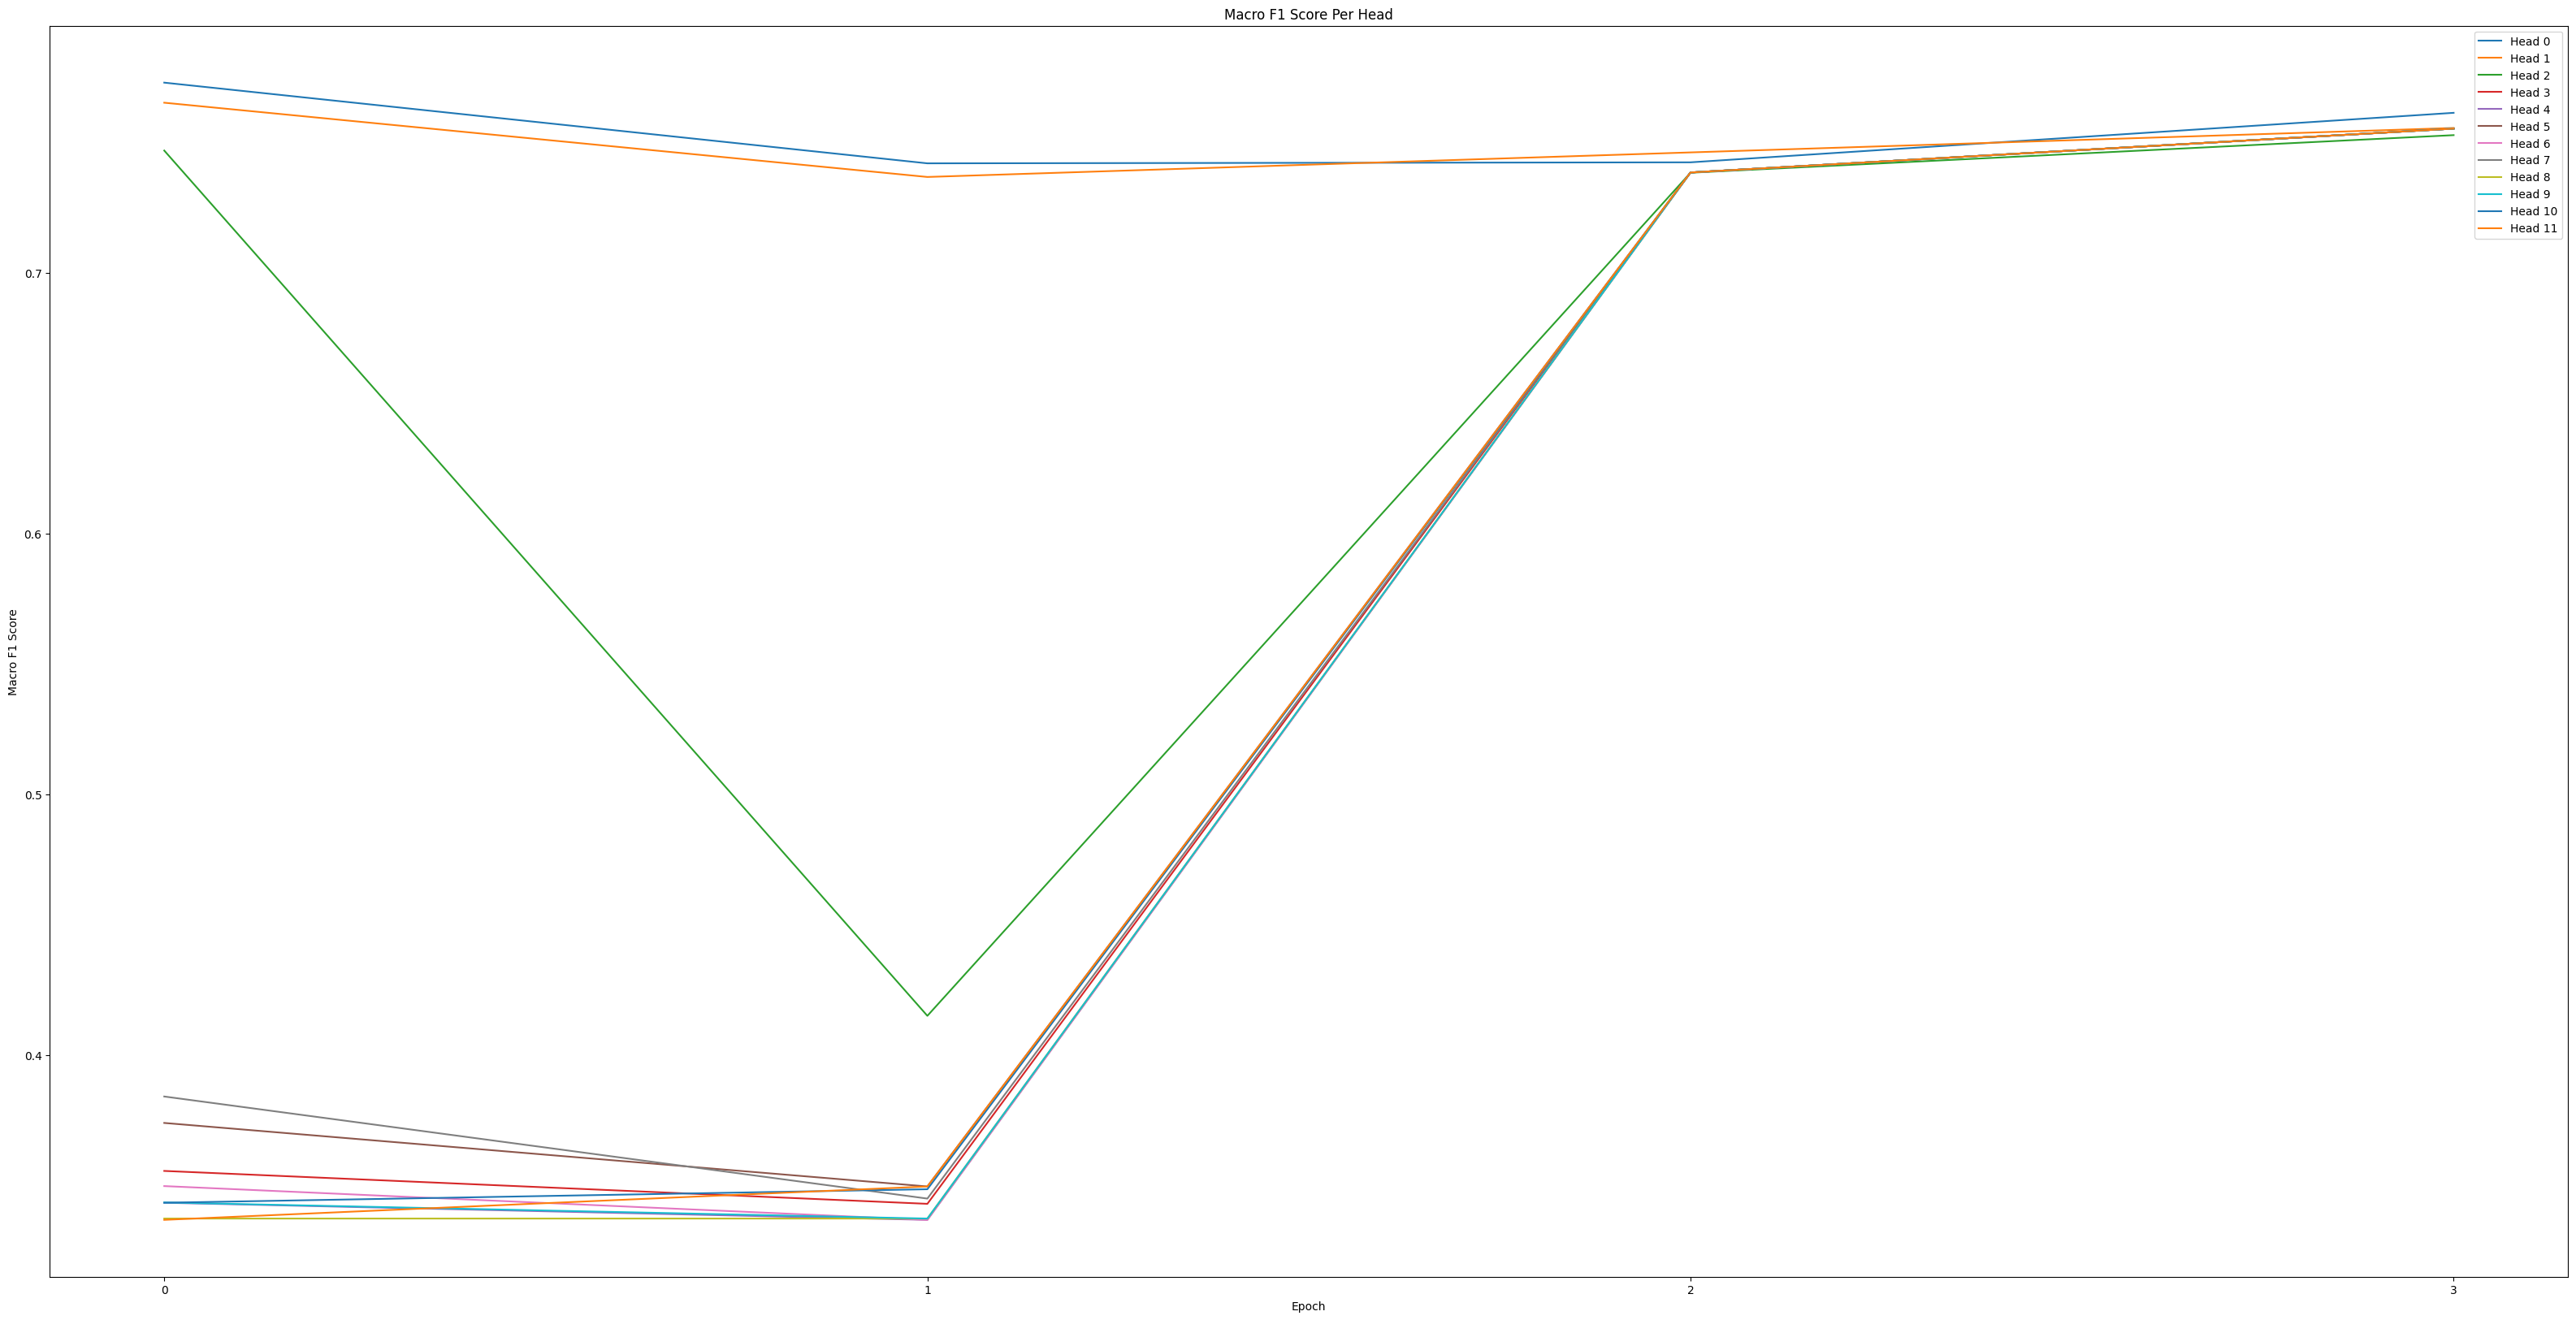

In [ ]:
# plot validation stats
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(style='darkgrid')
# sns.set(font_scale=1.5)
# plt.rcParams["figure.figsize"] = (12,6)

# print macrof1
val_macrof1_per_head = {}
for i in range(12):
    val_macrof1_per_head[i] = [stat['val_metrics'][i]['macro avg']['f1-score'] for stat in all_stats]
for i in range(12):
    plt.plot(val_macrof1_per_head[i], label='Head {}'.format(i))
# x axis is 1,2,3,4 epochs
plt.xticks([i for i in range(epochs)])
plt.xlabel('Epoch')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score Per Head')
plt.legend()
# increase the size of the plot to make it more readable
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

In [ ]:
test_macrof1_per_head = {}
for i in range(12):
    test_macrof1_per_head[i] = [stat['test_metrics'][i]['macro avg']['f1-score'] for stat in all_stats]
for i in range(12):
    plt.plot(test_macrof1_per_head[i], label='Head {}'.format(i))
# x axis is 1,2,3,4 epochs
plt.xticks([i for i in range(epochs)])
plt.xlabel('Epoch')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score Per Head')
plt.legend()
# increase the size of the plot to make it more readable
plt.rcParams["figure.figsize"] = (20,10)
plt.show()